# Example of electrostatic shielding by conductive objects

Demonstration of electrostatic shielding in a multiconductor case make use of numerical solution of Laplace equation with boundary conditions, to show redistribution of charges for a collection of conductors and how inside a shielding box (electrode 2) the fields and charges inside are unaffected by the outside charges. Note that the surface charges on the inside of the shielding box DO change in order to keep the internal field and the charges on electrode 1 from changing when external changes (V3 and V4) are applied
(C) Jo Verbeeck, EMAT, University of Antwerp, sept 2019

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

Create a 2D grid to keep it simple (3D takes longer to calculate and is harder to visualise, but the concept is the same)

In [3]:
#define grid
xmax=1 #extents of grid [m]
xpoints=256 #number of grid points to calculate
x=np.linspace(-xmax,xmax,xpoints)
y=np.linspace(-xmax,xmax,xpoints)
x2d,y2d=np.meshgrid(x,y)
r=np.sqrt(np.square(x2d)+np.square(y2d))

Define shape of 4 electrodes, we use logic function to define where on the grid an object is present (1) or not present (0)

In [4]:
gap=xmax/8 #defines gap
w=xmax/10

electrode1=np.multiply(r<gap/2,x2d<0) #half disc inside shielding ring
electrode2=np.multiply(r>gap,r<(gap+w)) #shielding ring
electrode3=np.sqrt(np.square(x2d-4*gap)+np.square(y2d))<gap #disc outside shielding
electrode4=np.sqrt(np.square(y2d-4*gap)+np.square(x2d))<gap #another disc outside shielding
#define the potential on each electrode
v1=10
v2=0 #assume shield is at gnd potential (arbitrary, but this is convention)
v3=1
v4=10

allelectrode=electrode1+electrode2+electrode3+electrode4
vac=allelectrode<1 #logic function defining the vacuum region where no electrodes are present

v=v1*electrode1+v2*electrode2+v3*electrode3+v4*electrode4 #potential boundary conditions=known constant potential on the electrodes

idelectrode=np.where(vac==0) #index for all points that contain electrodes
idvac=np.where(vac==1) #index for all points in vacuum


Show the electrode setup and their potential

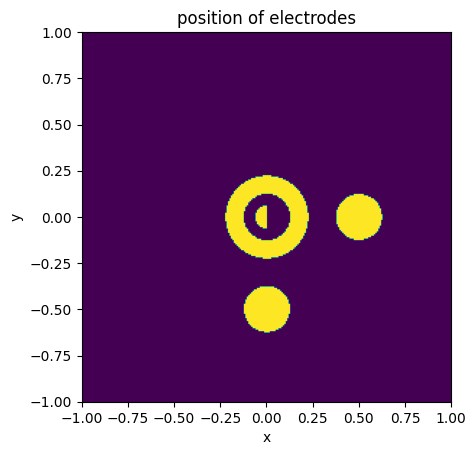

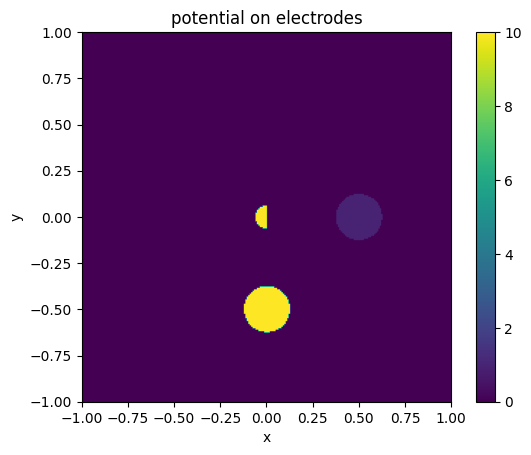

In [5]:

plt.imshow(allelectrode,extent=[-xmax,xmax,-xmax,xmax])
plt.axis('square')
plt.title('position of electrodes')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.imshow(v,extent=[-xmax,xmax,-xmax,xmax])
plt.axis('square')
plt.title('potential on electrodes')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

Now solve the Laplace equation for vacuum with boundary conditions 
first rough attempt: all vacuum points to average potential on electrodes (this is clearly too crude but we need to start somewhere)

In [6]:
v[idvac]=np.mean(v[idelectrode]) #replace vacuum potential by the mean potential on the electrodes

Now apply a relaxation method to itteratively find the solution to the laplace equation.
We take each step and smooth the solution with a smoothing kernel (technically we convolve the potential with the kernel)
The kernel is a crude numerical approximation to the mean value theorem stating that the potential inside a sphere is equal to the average potential on the surface of that sphere if no charges are present inside the sphere. 
Faster algorithms exist that start with a rough grid and refine the grid in the process, also the first guess for potential could be a lot smarter when e.g. taking a weighted average depending on distance


In [7]:
vn=v #starting condition is first rough estimate
kmax=1000 #number of itteration steps

kernel=np.array([[1/4,0,1/4],[0,0,0],[1/4,0,1/4]]) #approximative Laplace kernel replacing the central point by the average of 4 neighbouring points. 
error=np.zeros(kmax)

for k in range(kmax):
    vold=vn
    vn=signal.convolve(vold,kernel,mode="same")  #apply kernel to old estimate
    vn[idelectrode]=v[idelectrode] #and reinforce the boundary conditions (on the electrodes we KNOW the potentials)
    dif=vold-vn #difference between old and new estimate
    error[k]=np.sum(np.square(dif)) #square difference as indicator of convergence
   
    #imagesc(Vn); %see how the potential evolves while calculating (but
    #takes a lot of time that should really go to the calculation and not
    #to plotting
    #pause(0.1); %to force refreshing everytime we come here, otherwise the image is not updated

Text(0.5, 0, 'iteration')

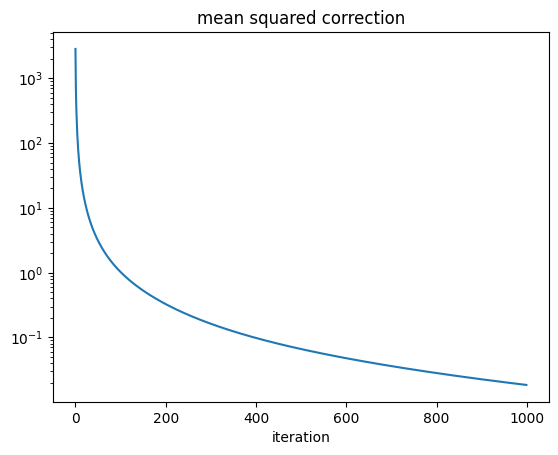

In [8]:
plt.semilogy(error)
plt.title('mean squared correction')
plt.xlabel('iteration')

(-1.0, 1.0, -1.0, 1.0)

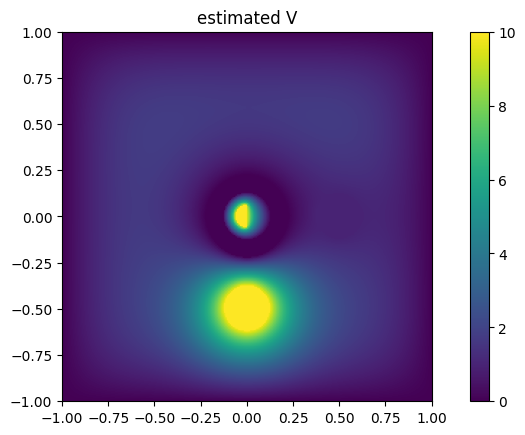

In [9]:
plt.imshow(vn,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('estimated V')
plt.axis('square')

Now get the fields from E=-grad(V)

In [10]:
ex,ey=np.gradient(-vn,x,y)
e=np.sqrt(np.square(ex)+np.square(ey))

(-1.0, 1.0, -1.0, 1.0)

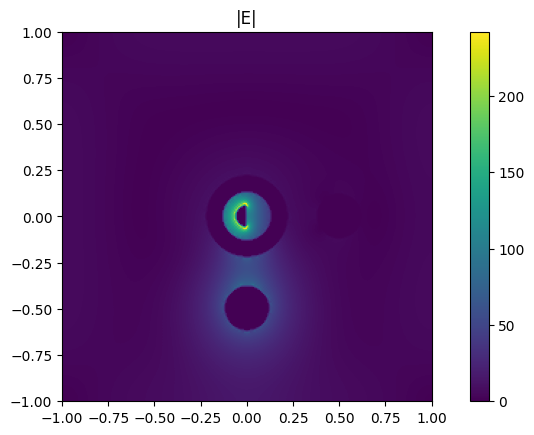

In [11]:
plt.imshow(e,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('|E|')
plt.axis('square')

Note how the potential of the inner half-moon electrode does not influence the region outside the shield (hence it is shielding). Try this by varying the potentials of the different electrodes and see what happens.

Now we can calculate the charge density via the divergence of E (alternatively we could calculate the Laplacian of V)

(-1.0, 1.0, -1.0, 1.0)

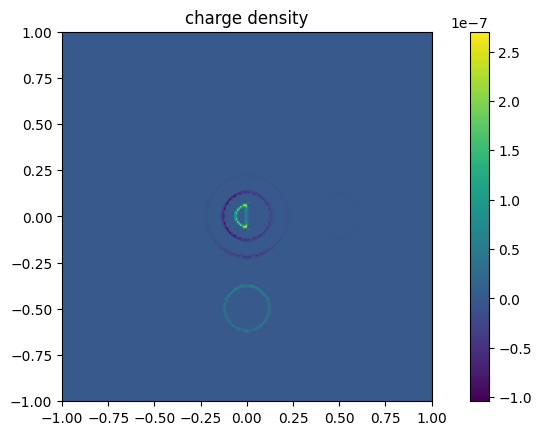

In [12]:
eps0=8.854e-12
dexdx,dexdy=np.gradient(ex,x,y)
deydx,deydy=np.gradient(ey,x,y)
div=dexdx+deydy #apparantly there is no divergence operator in numpy...so we write one ourselves
rho=eps0*div
plt.imshow(rho,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('charge density')
plt.axis('square')

Note how charge only appears on the surface of the conductors (as it should). Note also how a redistribution in surface charge on the inside of the shield is caused by changes in the inner electrode while the outer electrodes cause changes on the outside surface charge of the shield. Hence we understand that the redistribution of the surface charges in a metal shield is what is really causing the shield to act as a shield. This is also a reason why a nonconductive object would not act as a shield as it has no free charges.

## Would shielding still work if there are holes in the shield?

Lets punch some holes in the shield and see how that affects the shielding. Often holes are needed to either allow for cooling of things which are inside the shield or to look through the shield (check the door of your microwave oven and ask the question why your nose doesn't burn when you watch you food heat up.)

In [13]:
theta=np.arctan2(x2d,y2d) #polar coordinate
n=8
holes=np.sin(n*theta)>0 #binary pattern
electrode2=electrode2*holes #only keep the shield if the hole pattern is 1 (logical AND between shield and hole, here expressed a a multiplication of things that can either be 0 or 1)

#redefine what is electrode and what is vacuum
allelectrode=electrode1+electrode2+electrode3+electrode4
vac=allelectrode<1 #logic function defining the vacuum region where no electrodes are present
v=v1*electrode1+v2*electrode2+v3*electrode3+v4*electrode4 #potential boundary conditions=known constant potential on the electrodes
idelectrode=np.where(vac==0) #index for all points that contain electrodes
idvac=np.where(vac==1) #index for all points in vacuum

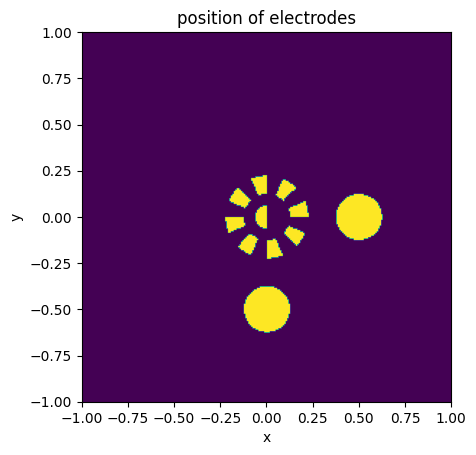

In [14]:
plt.imshow(allelectrode,extent=[-xmax,xmax,-xmax,xmax])
plt.axis('square')
plt.title('position of electrodes')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We run the numerical solution again with these new boundary conditions. In order to do this efficiently we will create a helper function to avoid having to retype the same code over and over again (and risk that the different copies may have slightly different function due to typo's and corrections in one which did not occur in the copy).

In [18]:
def laplacesolver(vinit, idvac, idelectrode, kmax):
    #solve laplace equation on a grid
    #for kmax iterrations
    #idvac are indices into the grid indicating where the vacuum region is
    #idelectrode are indices on the grid that indicate where the electrodes are with a fixed potential given in the input vinit (vinit in vacuum pixels is ignored)

    vinit[idvac]=np.mean(vinit[idelectrode]) #replace vacuum potential by the mean potential on the electrodes
    vn=vinit #starting condition is first rough estimate

    kernel=np.array([[1/4,0,1/4],[0,0,0],[1/4,0,1/4]]) #approximative Laplace kernel replacing the central point by the average of 4 neighbouring points. 
    error=np.zeros(kmax)

    for k in range(kmax):
        vold=vn
        vn=signal.convolve(vold,kernel,mode="same")  #apply kernel to old estimate
        vn[idelectrode]=v[idelectrode] #and reinforce the boundary conditions (on the electrodes we KNOW the potentials)
        dif=vold-vn #difference between old and new estimate
        error[k]=np.sum(np.square(dif)) #square difference as indicator of convergence
    return vn,error

Now we solve the Laplace equation for 2 different boundary conditions, one where V4=+10V and another where V4=-10V with the goal to identify how the other electrodes and the free space between them react to this change.

(-1.0, 1.0, -1.0, 1.0)

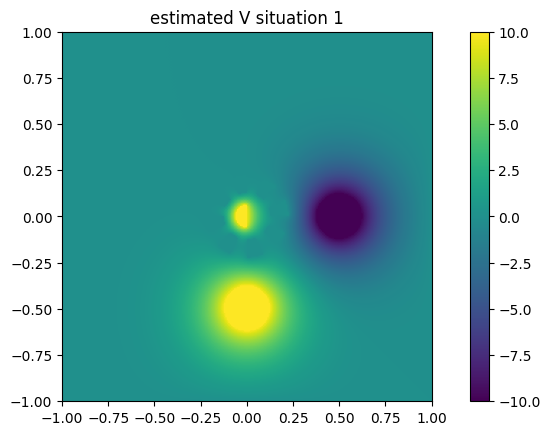

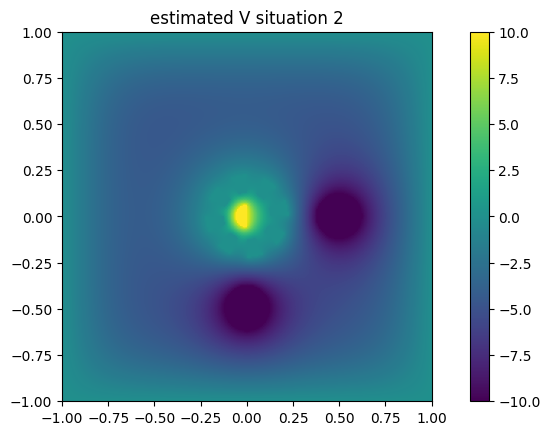

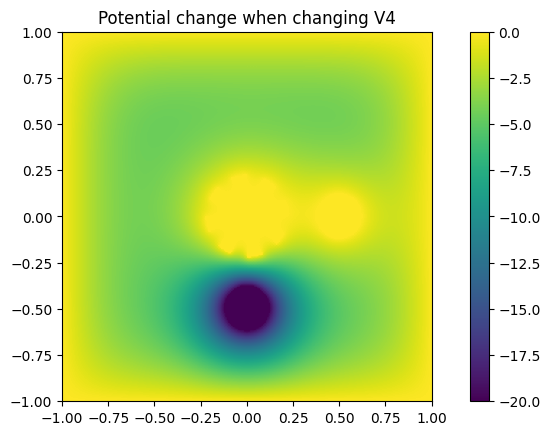

In [52]:
kmax=1000

#one set of boundary conditions
v1=10
v4=10
v=v1*electrode1+v2*electrode2+v3*electrode3+v4*electrode4 #potential boundary conditions=known constant potential on the electrodes
vn1,error=laplacesolver(v,idvac,idelectrode,kmax)

#and a different boundary condition
v4=-10
v1=10
v=v1*electrode1+v2*electrode2+v3*electrode3+v4*electrode4 #potential boundary conditions=known constant potential on the electrodes
vn2,error=laplacesolver(v,idvac,idelectrode,kmax)

#and show the potentials
plt.figure()
plt.imshow(vn1,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('estimated V situation 1')
plt.axis('square')

plt.figure()
plt.imshow(vn2,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('estimated V situation 2')
plt.axis('square')

#and plot the difference in potential which inside the shield should be zero
plt.figure()
plt.imshow(vn2-vn1,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('Potential change when changing V4')
plt.axis('square')


Lets define some other helper functions to avoid having to duplicate code

In [48]:
def getfield(v,x,y):
    #E=-grad V
    ex,ey=np.gradient(-v,x,y)
    return ex,ey
def getrho(v,x,y):
    ex,ey=getfield(v,x,y)
    #rho=eps0*div E
    eps0=8.854e-12
    dexdx,dexdy=np.gradient(ex,x,y)
    deydx,deydy=np.gradient(ey,x,y)
    div=dexdx+deydy #apparantly there is no divergence operator in numpy...so we write one ourselves
    rho=eps0*div
    return rho



And now calculate the charge density for the 2 situation and plot the change in charge density as a result of the change of potential on 1 of the electrodes.

(-1.0, 1.0, -1.0, 1.0)

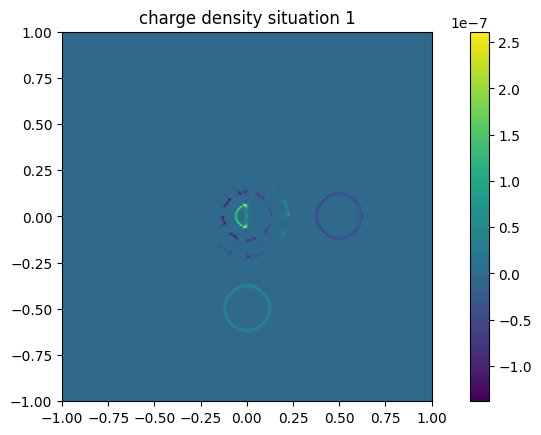

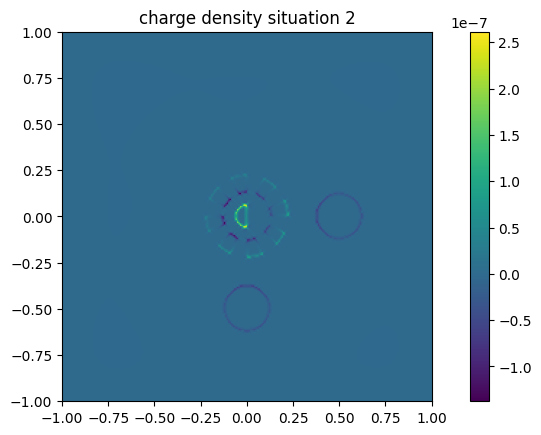

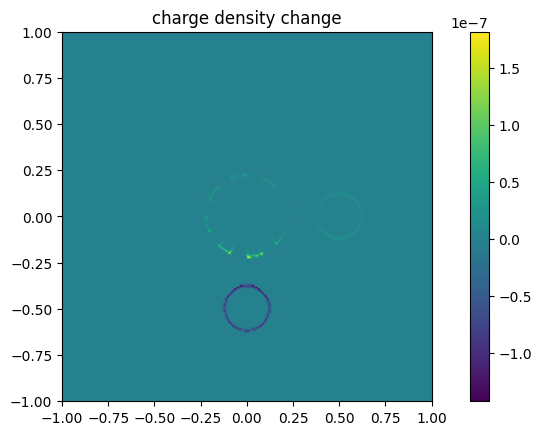

In [51]:
rho1=getrho(vn1,x,y)
rho2=getrho(vn2,x,y)


plt.figure()
plt.imshow(rho1,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('charge density situation 1')
plt.axis('square')
plt.figure()
plt.imshow(rho2,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('charge density situation 2')
plt.axis('square')
plt.figure()
plt.imshow(rho2-rho1,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('charge density change when changing V4')
plt.axis('square')

Note that the shielding still works. The biggest change in charge density is on the electrode that we are changing (bottom center). The electrode on the moddle right reacts to this change becuase it feels the change in potential and redistributes its charges accordingly to keep its internal from having an electric field. The inner surface of the shield does not change while the outer surface changes quite a lot. Note that the electrode inside the shield with holes does not change surface charge state as it should for an object inside a shield.
When the hole gets very large, this will break down and the shielding will get less effective. As a rule of thumb one could argue that the holes need to be smaller than the minimal distance of the object away from the shield. So if the shielding cage can be large with respect to the object that needs to be shielded, a very open shield may be sufficient. A lightning diverting system consisting of a few cables on the roof of a mountain hut may be an example of such a case. Note that for shielding time varying high frequency fields, other rules related to wavelength will also apply (relevant to your microwave oven door) but this would go way beyond this first chapter of the course.